In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model


In [ ]:
# Load MNIST data
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # shape: (60000, 28, 28, 1)

# Downscale to 7x7 then upscale to 28x28
x_small = tf.image.resize(x_train, [7, 7], method='area')
x_upscaled = tf.image.resize(x_small, [28, 28], method='nearest')

# Combine original + upscaled
images = tf.concat([x_train, x_upscaled], axis=0).numpy()
labels = np.concatenate([y_train], axis=0)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x_train = tf.concat([x_train], axis=0).numpy()
y_train_labels = np.concatenate([y_train], axis=0)

In [ ]:
x_upscaled = tf.concat([x_upscaled], axis=0).numpy()
y_upscaled_labels = np.concatenate([y_train], axis=0)

In [ ]:
import numpy as np
import random

def create_quadruplets(x_train, x_upscaled, y_train, num_quadruplets=100000):
    label_to_indices = {i: np.where(y_train == i)[0] for i in range(10)}
    quadruplets = set()

    while len(quadruplets) < num_quadruplets:
        # Select anchor class
        anchor_label = random.choice(range(10))
        positive_hr_idx = random.choice(label_to_indices[anchor_label])
        positive_lr_idx = random.choice(label_to_indices[anchor_label])

        # Select negative classes (different from anchor)
        negative_label_hr = random.choice([l for l in range(10) if l != anchor_label])
        negative_label_lr = random.choice([l for l in range(10) if l != anchor_label])
        negative_hr_idx = random.choice(label_to_indices[negative_label_hr])
        negative_lr_idx = random.choice(label_to_indices[negative_label_lr])

        # Store quadruplet as tuple of indices
        quadruplet = (positive_hr_idx, positive_lr_idx, negative_hr_idx, negative_lr_idx)

        if quadruplet not in quadruplets:
            quadruplets.add(quadruplet)

    pos_hr, pos_lr, neg_hr, neg_lr = [], [], [], []
    for positive_hr_idx, positive_lr_idx, negative_hr_idx, negative_lr_idx in quadruplets:
        pos_hr.append(x_train[positive_hr_idx])
        pos_lr.append(x_upscaled[positive_lr_idx])
        neg_hr.append(x_train[negative_hr_idx])
        neg_lr.append(x_upscaled[negative_lr_idx])

    return np.array(pos_hr), np.array(pos_lr), np.array(neg_hr), np.array(neg_lr)


In [ ]:
def build_embedding_model():
    inputs = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(8, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(32, activation='relu')(x)

    x = layers.Dropout(0.3)(x)

    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    return Model(inputs, x, name="QuarupletModel")

In [ ]:
class DualMarginScheduler(tf.keras.callbacks.Callback):
    def __init__(self, margin_hr_var, margin_lr_var, hr_schedule, lr_schedule):
        super().__init__()
        self.margin_hr_var = margin_hr_var
        self.margin_lr_var = margin_lr_var
        self.hr_schedule = hr_schedule
        self.lr_schedule = lr_schedule

    def on_epoch_begin(self, epoch, logs=None):
        new_hr_margin = self.hr_schedule(epoch)
        new_lr_margin = self.lr_schedule(epoch)
        self.margin_hr_var.assign(new_hr_margin)
        self.margin_lr_var.assign(new_lr_margin)
        print(f"Epoch {epoch}: HR margin = {new_hr_margin}, LR margin = {new_lr_margin}")

In [ ]:
margin_hr_var = tf.Variable(0.5)
margin_lr_var = tf.Variable(0.5)

def quadruplet_loss():
    def loss(y_true, y_pred):
        positive_hr, positive_lr, negative_hr, negative_lr = tf.split(y_pred, 4, axis=1)
        pos_dist = tf.reduce_sum(tf.square(positive_hr - positive_lr), axis=1)
        neg_dist_hr = tf.reduce_sum(tf.square(positive_hr - negative_hr), axis=1)
        neg_dist_lr = tf.reduce_sum(tf.square(positive_lr - negative_lr), axis=1)

        hr_loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist_hr + margin_hr_var, 0.0))
        lr_loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist_lr + margin_lr_var, 0.0))

        return (hr_loss + lr_loss)
    return loss



In [ ]:
def hr_schedule(epoch):
    return 0.6

def lr_schedule(epoch):
    return 0.4

In [ ]:
def build_siamese_model(embedding_model):
    input_positive_hr = layers.Input(shape=(28, 28, 1))
    input_positive_lr = layers.Input(shape=(28, 28, 1))
    input_negative_hr = layers.Input(shape=(28, 28, 1))
    input_negative_lr = layers.Input(shape=(28, 28, 1))

    embed_positive_hr = embedding_model(input_positive_hr)
    embed_positive_lr = embedding_model(input_positive_lr)
    embed_negative_hr = embedding_model(input_negative_hr)
    embed_negative_lr = embedding_model(input_negative_lr)

    output = layers.concatenate([embed_positive_hr, embed_positive_lr, embed_negative_hr, embed_negative_lr], axis=1)

    return Model(inputs=[input_positive_hr, input_positive_lr, input_negative_hr, input_negative_lr], outputs=output)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    min_delta=1e-4,
    restore_best_weights=True
)


In [ ]:
positive_hr, positive_lr, negative_hr,  negative_lr = create_quadruplets(x_train, x_upscaled, labels, num_quadruplets=100000)

In [ ]:


embedding_model = build_embedding_model()
siamese_model = build_siamese_model(embedding_model)


siamese_model.compile(optimizer='adam', loss=quadruplet_loss())


siamese_model.fit(
    [positive_hr, positive_lr, negative_hr, negative_lr],
    np.zeros(len(positive_hr)),
    batch_size=64,
    epochs=30,
    callbacks=[DualMarginScheduler(margin_hr_var, margin_lr_var, hr_schedule, lr_schedule), early_stopping]
)


Epoch 0: HR margin = 0.6, LR margin = 0.4
Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 113s 69ms/step - loss: 0.3904
Epoch 1: HR margin = 0.6, LR margin = 0.4
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 67ms/step - loss: 0.1863
Epoch 2: HR margin = 0.6, LR margin = 0.4
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - loss: 0.1708
Epoch 3: HR margin = 0.6, LR margin = 0.4
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 68ms/step - loss: 0.1591
Epoch 4: HR margin = 0.6, LR margin = 0.4
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 110s 70ms/step - loss: 0.1511
Epoch 5: HR margin = 0.6, LR margin = 0.4
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 68ms/step - loss: 0.1466
Epoch 6: HR margin = 0.6, LR margin = 0.4
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 68ms/step - loss: 0.1348
Epoch 7: HR margin = 0.6, LR margin = 0.4
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 68ms/step - loss: 0.1291
Epoch 8: HR margin = 0.6, LR margin = 0.4
Epoch 9/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s

In [ ]:
(_, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, axis=-1)  #


In [ ]:
x_test_small = tf.image.resize(x_test, [7, 7], method='area')
x_test_upscaled = tf.image.resize(x_test_small, [28, 28], method='nearest')

In [ ]:
x_test_combined = tf.concat([x_test,x_test_upscaled], axis=0).numpy()  #
y_test_combined = np.concatenate([y_test,y_test], axis=0)  #


In [ ]:
images = tf.concat([x_train, x_upscaled], axis=0).numpy()
labels = np.concatenate([y_train, y_train], axis=0)

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
k-NN Accuracy on combined test set: 0.9738
Macro F1 Score: 0.9734

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1960
           1       0.99      0.99      0.99      2270
           2       0.97      0.98      0.98      2064
           3       0.96      0.97      0.97      2020
           4       0.97      0.97      0.97      1964
           5       0.97      0.97      0.97      1784
           6       0.98      0.98      0.98      1916
           7       0.97      0.98      0.97      2056
           8       0.97      0.96      0.96      1948
           9       0.97      0.95      0.96      2018

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



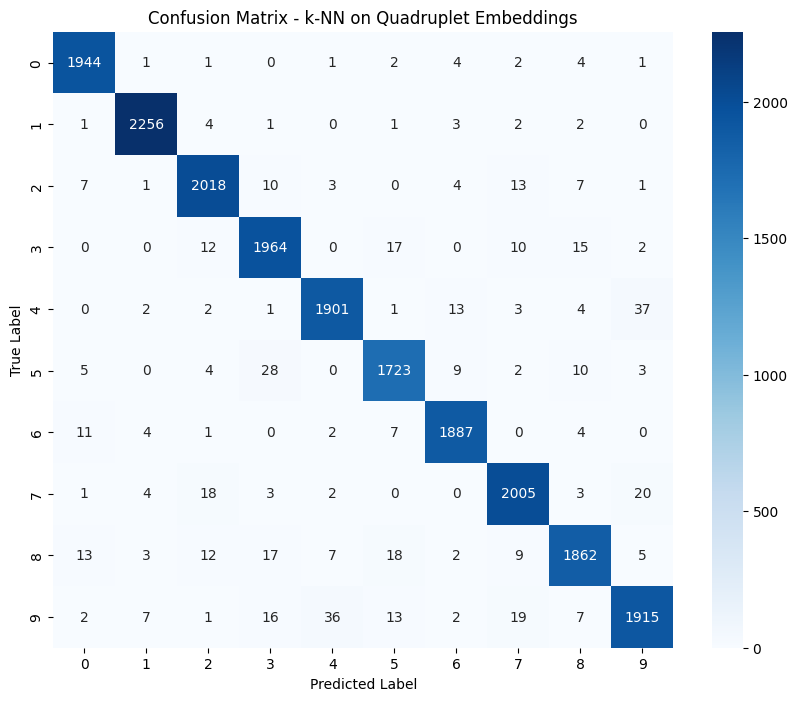

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get training embeddings
x_train_embed = embedding_model.predict(images, batch_size=256)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_embed, labels)

# Get test embeddings
x_test_embed = embedding_model.predict(x_test_combined, batch_size=256)

# Predict and evaluate
y_pred = knn.predict(x_test_embed)

# Accuracy
acc = accuracy_score(y_test_combined, y_pred)
print(f"k-NN Accuracy on combined test set: {acc:.4f}")

# F1 Score
f1 = f1_score(y_test_combined, y_pred, average='macro')
print(f"Macro F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_combined, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_combined, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix - k-NN on Quadruplet Embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
embed_images = x_test_combined
embed_labels = y_test_combined

In [ ]:
embeddings = embedding_model.predict(embed_images)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

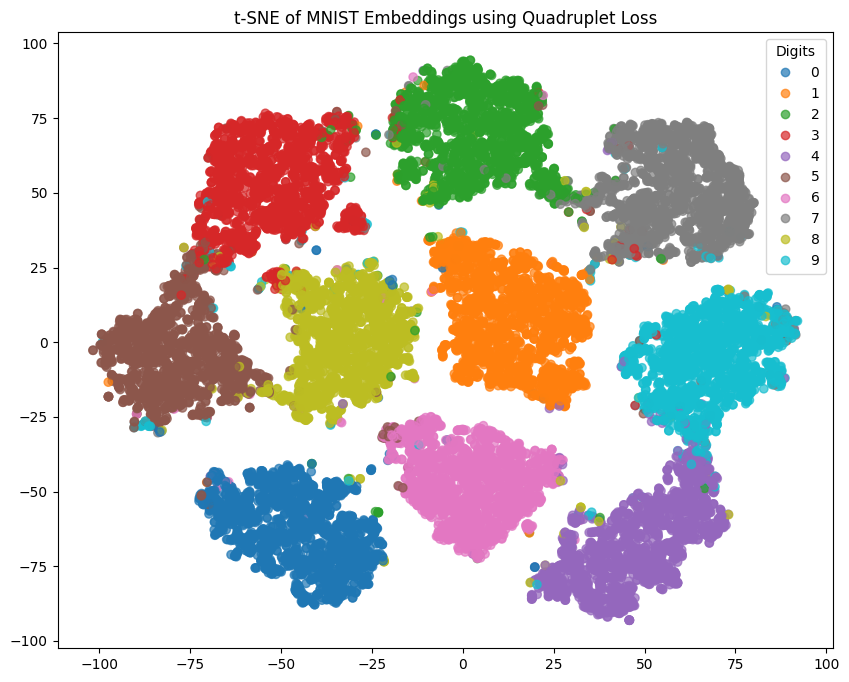

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=embed_labels.astype(int), cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("t-SNE of MNIST Embeddings using Quadruplet Loss")
plt.grid(False)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report

In [ ]:
import pandas as pd
f1 = f1_score(y_test_combined, y_pred, average='macro')
print(f"Macro F1 Score: {f1:.4f}")

print(classification_report(y_test_combined, y_pred,))





Macro F1 Score: 0.9734
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1960
           1       0.99      0.99      0.99      2270
           2       0.97      0.98      0.98      2064
           3       0.96      0.97      0.97      2020
           4       0.97      0.97      0.97      1964
           5       0.97      0.97      0.97      1784
           6       0.98      0.98      0.98      1916
           7       0.97      0.98      0.97      2056
           8       0.97      0.96      0.96      1948
           9       0.97      0.95      0.96      2018

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [ ]:
df_report.style.format("{:.2f}").set_caption("Classification Report")

NameError: name 'df_report' is not defined

In [ ]:
df_report.to_html("classification_report.html")

In [ ]:
from google.colab import files
files.download('classification_report.html')

In [ ]:
label_to_indices = {i: np.where(y_train == i)[0] for i in range(10)}
quadruplets = []

for _ in range(1):
    # Select anchor class
    anchor_label = random.choice(range(10))
    positive_hr_idx = random.choice(label_to_indices[anchor_label])
    positive_lr_idx = random.choice(label_to_indices[anchor_label])

    # Select negative class (different from anchor)
    negative_label_hr = random.choice([l for l in range(10) if l != anchor_label])
    negative_label_lr = random.choice([l for l in range(10) if l != anchor_label])
    negative_hr_idx = random.choice(label_to_indices[negative_label_hr])
    negative_lr_idx = random.choice(label_to_indices[negative_label_lr])

    # Anchor and positive from x_train (HQ)
    positive_hr = x_train[positive_hr_idx]
    positive_lr = x_upscaled[positive_lr_idx]

    # Negatives from x_upscaled (LQ)
    negative_hr = x_train[negative_hr_idx]
    negative_lr = x_upscaled[negative_lr_idx]

    quadruplets.append((positive_hr, positive_lr, negative_hr, negative_lr))
    print(anchor_label)
    print(positive_hr_idx)
    print(positive_lr_idx)
    print(negative_label_hr)
    print(negative_label_lr)
    print(negative_hr_idx)
    print(negative_lr_idx)
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 4, 1)
    plt.imshow(quadruplets[0][0], cmap='gray')
    plt.colorbar()

    # Resized image
    plt.subplot(1, 4, 2)
    plt.imshow(quadruplets[0][1], cmap='gray')
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.imshow(quadruplets[0][2], cmap='gray')
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.imshow(quadruplets[0][3], cmap='gray')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Show the anchor image from the first quadruplet
anchor_img = x_upscaled[45148]

plt.imshow(anchor_img.squeeze(), cmap='gray')  # .squeeze() removes the channel dimension
plt.title("Anchor Image")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Show the anchor image from the first quadruplet
anchor_img = x_train[45148]

plt.imshow(anchor_img.squeeze(), cmap='gray')  # .squeeze() removes the channel dimension
plt.title("Anchor Image")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Show the anchor image from the first quadruplet
anchor_img = quadruplets[0][1]

plt.imshow(anchor_img.squeeze(), cmap='gray')  # .squeeze() removes the channel dimension
plt.title("Anchor Image")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Show the anchor image from the first quadruplet
anchor_img = quadruplets[0][2]

plt.imshow(anchor_img.squeeze(), cmap='gray')  # .squeeze() removes the channel dimension
plt.title("Anchor Image")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Show the anchor image from the first quadruplet
anchor_img = quadruplets[0][3]

plt.imshow(anchor_img.squeeze(), cmap='gray')  # .squeeze() removes the channel dimension
plt.title("Anchor Image")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np

# Load MNIST data
(x_train, y_train), (_, _) = mnist.load_data()

# Prepare a dictionary to store one example of each digit
digit_examples = {}

# Loop through the dataset and get one sample per digit
for img, label in zip(x_train, y_train):
    if label not in digit_examples:
        digit_examples[label] = img
    if len(digit_examples) == 10:
        break

# Plot the digits
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(digit_examples[i], cmap='gray')
    plt.title(str(i))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


x_upscaled

In [ ]:
digit_examples = {}

# Loop through the dataset and get one sample per digit
for img, label in zip(x_upscaled, y_train):
    if label not in digit_examples:
        digit_examples[label] = img
    if len(digit_examples) == 10:
        break

# Plot the digits
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(digit_examples[i], cmap='gray')
    plt.title(str(i))
    plt.axis('off')
plt.tight_layout()
plt.show()